# NBA Assist Networks

Similar to tutorial about [WNBA Assist Networks](https://github.com/basketballrelativity/assist_networks/blob/master/wnba_assist_networks.ipynb), this tutorial dives into the NBA side and demonstrates how to build assist networks using data from [stats.nba.com](https://stats.nba.com).

The following explores the `PlayByPlay` and `Player` classes of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `playbyplayv2` and `shotchartdetail` endpoint of the [stats.nba.com](https://stats.nba.com). The goal of this analysis is to follow the same methodology as used on the WNBA side to generate assist networks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

from PIL import Image
import time

from py_ball import playbyplay, player

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `PlayByPlay` class requires just one parameter:
- game_id: The unique identifier for the game of interest

The following pulls play-by-play data for a 2019 NBA Finals game between the Raptors and the Warriors.

In [2]:
game_id = '0041800403'
plays = playbyplay.PlayByPlay(headers=HEADERS,
                              endpoint='playbyplayv2',
                              game_id=game_id)

play_df = pd.DataFrame(plays.data['PlayByPlay'])
play_df.head(35)

,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,...,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
0,0,12,2,0041800403,None,None,12:00,1,0,0,...,0,None,None,None,NaN,None,None,None,None,9:11 PM
1,0,10,4,0041800403,Jump Ball Cousins vs. Gasol: Tip to Livingston,None,12:00,1,4,5,...,2733,Shaun Livingston,GSW,Golden State,1.610613e+09,Warriors,None,None,None,9:11 PM
2,1,2,7,0041800403,MISS Curry 26' 3PT Jump Shot,None,11:45,1,4,0,...,0,None,None,None,NaN,None,None,None,None,9:12 PM
3,0,4,8,0041800403,None,None,11:43,1,5,0,...,0,None,None,None,NaN,None,None,None,Siakam REBOUND (Off:0 Def:1),9:12 PM
4,2,6,9,0041800403,Livingston S.FOUL (P1.T1) (D.Guthrie),None,11:36,1,4,5,...,0,None,None,None,NaN,None,None,None,None,9:12 PM
5,11,3,11,0041800403,None,None,11:36,1,5,0,...,0,None,None,None,NaN,None,1 - 0,-1,Lowry Free Throw 1 of 2 (1 PTS),9:12 PM
6,12,3,12,0041800403,None,None,11:36,1,5,0,...,0,None,None,None,NaN,None,2 - 0,-2,Lowry Free Throw 2 of 2 (2 PTS),9:12 PM
7,1,2,13,0041800403,MISS Green 25' 3PT Jump Shot,None,11:22,1,4,0,...,0,None,None,None,NaN,None,None,None,None,9:13 PM
8,0,4,14,0041800403,Curry REBOUND (Off:1 Def:0),None,11:20,1,4,0,...,0,None,None,None,NaN,None,None,None,None,9:13 PM
9,63,1,15,0041800403,Curry 16' Fadeaway Jumper (2 PTS) (Livingston ...,None,11:16,1,4,4,...,0,None,None,None,NaN,None,2 - 2,TIE,None,9:13 PM


By examining the above play, which includes an assisted basket, we see that the player credited with the assist is included in the play-by-play data through the PLAYER2 fields. We need to join this table to shot location data using the EVENTNUM field.

The `shotchartdetail` endpoint accepts a variety of parameters, but only a few are relevant for shot probability purposes:

- league_id: '00' for the NBA, '10' for the WNBA
- player_id: The unique identifier for the player (0 returns shot data for the whole game)
- game_id: The unique identifier for the game of interest
- season: YYYY-ZZ season year format (This only affects the league averages returned)
- season_type: One of 'Regular Season', 'Pre Season', 'Playoffs', 'All Star'

In [3]:
league_id = '00' #NBA
player_id = '0' #All players
season = '2018-19'
season_type = 'Playoffs'

shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season,
                      season_type=season_type)
shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
shot_df.head(15)

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Jump Shot,Missed Shot,20190605,7,0041800403,Shot Chart Detail,GSW,192,179,11,...,1,26,0,3PT Field Goal,Right Side Center(RC),Above the Break 3,24+ ft.,1610612744,Golden State Warriors,TOR
1,Jump Shot,Missed Shot,20190605,13,0041800403,Shot Chart Detail,GSW,-49,245,11,...,1,24,0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612744,Golden State Warriors,TOR
2,Fadeaway Jump Shot,Made Shot,20190605,15,0041800403,Shot Chart Detail,GSW,161,20,11,...,1,16,1,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612744,Golden State Warriors,TOR
3,Running Pull-Up Jump Shot,Made Shot,20190605,24,0041800403,Shot Chart Detail,GSW,20,302,10,...,1,30,1,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612744,Golden State Warriors,TOR
4,Hook Shot,Made Shot,20190605,25,0041800403,Shot Chart Detail,GSW,-62,78,10,...,1,9,1,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612761,Toronto Raptors,TOR
5,Jump Shot,Missed Shot,20190605,26,0041800403,Shot Chart Detail,GSW,136,250,10,...,1,28,0,3PT Field Goal,Right Side Center(RC),Above the Break 3,24+ ft.,1610612744,Golden State Warriors,TOR
6,Jump Shot,Missed Shot,20190605,28,0041800403,Shot Chart Detail,GSW,-14,290,10,...,1,29,0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612761,Toronto Raptors,TOR
7,Running Finger Roll Layup Shot,Missed Shot,20190605,30,0041800403,Shot Chart Detail,GSW,2,51,9,...,1,5,0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612744,Golden State Warriors,TOR
8,Pullup Jump shot,Made Shot,20190605,32,0041800403,Shot Chart Detail,GSW,-228,13,9,...,1,22,1,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,1610612761,Toronto Raptors,TOR
9,Hook Shot,Made Shot,20190605,40,0041800403,Shot Chart Detail,GSW,4,69,9,...,1,6,1,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612761,Toronto Raptors,TOR


In [4]:
assist_df = shot_df.merge(play_df[['EVENTNUM',
                                   'HOMEDESCRIPTION',
                                   'VISITORDESCRIPTION',
                                   'PLAYER2_ID',
                                   'PLAYER2_NAME']], left_on='GAME_EVENT_ID', right_on='EVENTNUM')

assist_df = assist_df[pd.notnull(assist_df['PLAYER2_NAME'])]

In [5]:
assist_df.head().T

,2,8,11,19,20
ACTION_TYPE,Fadeaway Jump Shot,Pullup Jump shot,Jump Shot,Cutting Layup Shot,Pullup Jump shot
EVENT_TYPE,Made Shot,Made Shot,Made Shot,Made Shot,Made Shot
GAME_DATE,20190605,20190605,20190605,20190605,20190605
GAME_EVENT_ID,15,32,47,62,64
GAME_ID,0041800403,0041800403,0041800403,0041800403,0041800403
GRID_TYPE,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail
HTM,GSW,GSW,GSW,GSW,GSW
LOC_X,161,-228,2,-12,-3
LOC_Y,20,13,118,31,256
MINUTES_REMAINING,11,9,8,6,6


To create a network, we need to establish both nodes and edges. Each edge goes from a source node (assisting player) to a target node. The `network_data` function below also establishes coordinates for each node, along with the number of assists for each player. 

In [6]:
def network_data(pbp_df, team_id):
    """ network_dict creates nodes and edges
    for an assist network, along with information
    needed to plot the network

    @param pbp_df (DataFrame): DataFrame of play-by-play
        data with timeouts removed. Timeouts cause complications
        with getting players from the 'epid' field

    @param team_id (int): Unique team identifier

    Returns

        unique_players (list): List of player ID numbers
            corresponding to players on the team given

        edges (list): List of tuples in the form
            (assisting player ID, scoring player ID, number of assists)

        pos_dict (dict): Dictionary with keys of player ID numbers
            with (x, y) values corresponding to node coordinates

        weights (dict): Dictionary with keys of player ID numbers
            with assists as values
    """

    # First, let's identify all players on the team provided
    network = {}
    assist_df = pbp_df[pbp_df['TEAM_ID'] == team_id]
    unique_players = list(set(list(assist_df['PLAYER_ID']) + list(assist_df['PLAYER2_ID'])))
    unique_players = list(set([int(x) for x in unique_players]))

    # Next, we'll isolate the assists and loop through all unique assist
    # partners (assisting player, scorer)
    network['links'] = {}
    count = 0
    all_assists = zip(assist_df['PLAYER2_ID'], assist_df['PLAYER_ID'])
    all_assists = [(int(x), int(y)) for x, y in all_assists]
    unique_assists = list(set(all_assists))
    weights = {}
    for source, target in unique_assists:
        network['links'][count] = {}
        network['links'][count]['source'] = source
        network['links'][count]['target'] = target
        network['links'][count]['weight'] = sum([1 if x == (source, target) else 0 for x in all_assists])
        weights[(source, target)] = network['links'][count]['weight']
        count += 1

    links = len(network['links'])
    edges = [(network['links'][k]['source'],
              network['links'][k]['target'],
              network['links'][k]['weight']) for k in range(links)]

    # Finally, we'll get coordinates for all players in the assist
    # network around the unit circle
    angles = np.linspace(0, 360 - 360/float(len(unique_players)), len(unique_players))
    pos_dict = {}
    for angle, player in zip(angles, unique_players):
        pos_dict[player] = (np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle)))

    return unique_players, edges, pos_dict, weights

In [7]:
team_id = 1610612761
nodes, edges, positions, weights = network_data(assist_df, team_id)

Finally, we can write a function that uses `matplotlib` to visualize the assist network given the components created above. Let's first create a dictionary of names for display purposes.

In [8]:
team_df = assist_df[assist_df['TEAM_ID']==team_id]
team_name = team_df['TEAM_NAME'].iloc[0]
players = {}
unique_scorers = list(set(team_df['PLAYER_ID']))
for player in unique_scorers:
    if player not in players:
        players[player] = team_df[team_df['PLAYER_ID']==player]['PLAYER_NAME'].iloc[0]

unique_passers = list(set(team_df['PLAYER2_ID']))
for player in unique_passers:
    if player not in players:
        players[player] = team_df[team_df['PLAYER2_ID']==player]['PLAYER2_NAME'].iloc[0]

In [9]:
def plot_network(nodes, edges, positions, weights, players, team):
    """ plot_network plots the assist network given the
    data from the network_data function.

    @param nodes (list): List of player ID numbers
        corresponding to players on the team given

    @param edges (list): List of tuples in the form
        (assisting player ID, scoring player ID, number of assists)

    @param positions (dict): Dictionary with keys of player ID numbers
         with (x, y) values corresponding to node coordinates

    @param weights (dict): Dictionary with keys of player ID numbers
        with assists as values

    @param players (dict): Dict keyed by player IDs with their names
        as values

    @param team (str): Team name

    Returns

        fig (maplotlib.figure.Figure): Assist network visual
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')
    plt.title(team + ' Assist Network', fontsize=18)

    # First, let's plot each node, labeling each with player name and
    # number of assists. The number of assists also control the markersize
    # of the nodes. Because of this and varying name lengths, the name
    # position is perturbed to ensure proper formatting
    for pos in positions:
        assists = sum([weights[x] if x[0] == pos else 0 for x in weights])
        plt.plot(positions[pos][0], positions[pos][1], marker='o',
                 markersize=(1 + assists)*5, markeredgecolor='k', fillstyle='none')
        name = players[pos] + ' (' + str(int(assists)) + ')'
        if positions[pos][1] == 1:
            vertical_perturb = 0.003*(1 + assists)*5
        elif positions[pos][1] == -1:
            vertical_perturb = -0.005*(1 + assists)*5 - 0.05
        else:
            vertical_perturb = 0

        if positions[pos][0] < 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = -0.0325*len(name) - 0.0025*(1 + assists)*5
        elif positions[pos][0] >= 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = 0.0025*len(name) + 0.0025*(1 + assists)*5
        else:
            horiz_perturb = -0.0175*len(name)
            
        plt.text(positions[pos][0] + horiz_perturb, positions[pos][1] + vertical_perturb,
                 name, fontsize=12)

    # Next, the edges are plotted as arrows with the arrow going from 
    # the assisting player to the scoring player. The size of the arrow
    # is a function of the number of assists for that directed pair.
    # Also, the transparency is set to 0.5 to account for instances
    # when a pair of players have assists to each other.
    for edge in edges:
        node1 = edge[0]
        node2 = edge[1]
        assists = edge[2]

        start_x = positions[node1][0]
        start_y = positions[node1][1]

        delta_x = positions[node2][0] - start_x
        delta_y = positions[node2][1] - start_y

        plt.arrow(start_x, start_y, delta_x, delta_y, width=0.015*assists,
                  length_includes_head=True, alpha=0.5)

    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    axis.set_aspect(1.0)
    plt.axis('off')
    plt.close()

    return fig

In [10]:
network = plot_network(nodes, edges, positions, weights, players, team_name)

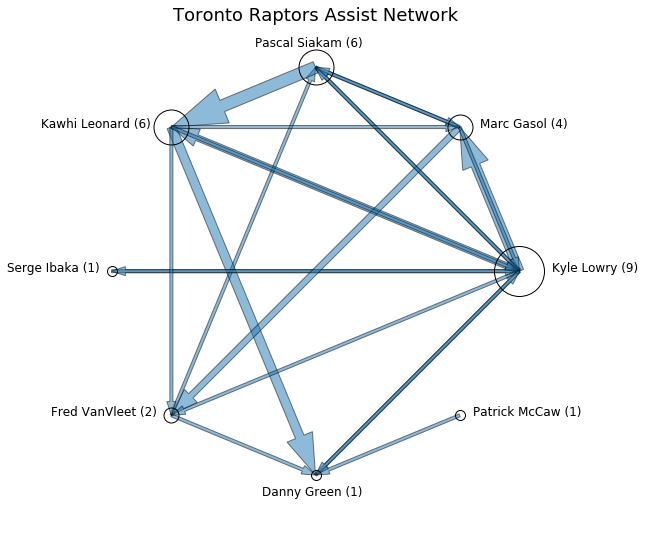

In [11]:
network

The assist network communicates a lot of information in a compact form:
    - Kyle Lowry led the team with nine assists and distributed them to six different teammates
    - Patrick McCaw had an assist but did not score an assisted basket
    - Danny Green was the beneficiary of six assists
    - The greatest number of assists from one player to another is four
    
## Exploration

    - What else can you add or change about the above assist network to enhance the visualization?
    - What other events in basketball could be visualized by a network?